<a href="https://colab.research.google.com/github/seenu-g/school_of_ai/blob/master/chap12/Trial5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "Albumentation library is successfully installed!"
!pip install --no-cache-dir git+https://github.com/NVIDIA/apex > /dev/null && echo "Apex library is successfully installed!"!

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-ufdt949c
Albumentation library is successfully installed!
  Running command git clone -q https://github.com/NVIDIA/apex /tmp/pip-req-build-t81rczxj
  Running command git submodule update --init --recursive -q
Apex library is successfully installed!!


In [2]:
# mount gdrive and unzip data
from google.colab import drive
import sys
%load_ext autoreload
%autoreload 2
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
import sys
import os
folder = '/content/gdrive/My Drive/school_of_ai/chap12/'
os.chdir(folder)
print(os.getcwd()) 
for items in os.listdir(folder):
   print(items)
sys.path.append(folder)

/content/gdrive/My Drive/school_of_ai/chap12
template
Trial1.ipynb
Trial2.ipynb
Trial5.ipynb


In [0]:
import torch
import torchvision
from template import TinyImageNet
from template import DatasetFromSubset
from template import download_extract
from template import Albumentationtransform
from template import chap12ResNet

In [5]:
IMAGES_URL = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
fileName = "tiny-imagenet-200.zip"
download_extract.download_images(IMAGES_URL)

In [6]:
def get_classes(download_folder):
    classes = []
    wnids = open(os.path.join(download_folder,"wnids.txt"), "r")
    for line in wnids:
        classes.append(line.strip())
    return classes

print(folder)
download_folder = folder + 'tiny-imagenet-200/'
if (os.path.isdir(download_folder)==False):
    print(download_folder," does not exist")
else :    
    classes = get_classes(download_folder)
    print(classes)

/content/gdrive/My Drive/school_of_ai/chap12/
['n02124075', 'n04067472', 'n04540053', 'n04099969', 'n07749582', 'n01641577', 'n02802426', 'n09246464', 'n07920052', 'n03970156', 'n03891332', 'n02106662', 'n03201208', 'n02279972', 'n02132136', 'n04146614', 'n07873807', 'n02364673', 'n04507155', 'n03854065', 'n03838899', 'n03733131', 'n01443537', 'n07875152', 'n03544143', 'n09428293', 'n03085013', 'n02437312', 'n07614500', 'n03804744', 'n04265275', 'n02963159', 'n02486410', 'n01944390', 'n09256479', 'n02058221', 'n04275548', 'n02321529', 'n02769748', 'n02099712', 'n07695742', 'n02056570', 'n02281406', 'n01774750', 'n02509815', 'n03983396', 'n07753592', 'n04254777', 'n02233338', 'n04008634', 'n02823428', 'n02236044', 'n03393912', 'n07583066', 'n04074963', 'n01629819', 'n09332890', 'n02481823', 'n03902125', 'n03404251', 'n09193705', 'n03637318', 'n04456115', 'n02666196', 'n03796401', 'n02795169', 'n02123045', 'n01855672', 'n01882714', 'n02917067', 'n02988304', 'n04398044', 'n02843684', 'n02

In [0]:
from torch.utils.data import Dataset, random_split
def TinyImageNetDataSet(train_split = 70,test_transforms = None,train_transforms = None):
  dataset = TinyImageNet.TinyImageNet(classes,download_folder)
  train_len = len(dataset)*train_split//100
  test_len = len(dataset) - train_len 
  train_set, val_set = random_split(dataset, [train_len, test_len])
  train_dataset = DatasetFromSubset.DatasetFromSubset(train_set, transform=train_transforms)
  test_dataset = DatasetFromSubset.DatasetFromSubset(val_set, transform=test_transforms)
  
  return train_dataset, test_dataset,classes

In [8]:
import albumentations as A
import cv2
train_transform = Albumentationtransform.AlbumentationTransforms([                              
                                      A.HorizontalFlip(p = 0.7),
                                      A.PadIfNeeded(min_height=70, min_width=70, border_mode=4, value=None, mask_value=None, always_apply=False, p=1.0),
                                      A.RandomCrop(64, 64, always_apply=False, p=1.0),
                                      A.Rotate(limit=50, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
                                      A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                                      A.Cutout(num_holes=1, max_h_size=32,max_w_size = 32,p=0.7) 
                                       ])
test_transform = Albumentationtransform.AlbumentationTransforms([A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
train_dataset , test_dataset,classes = TinyImageNetDataSet(train_split = 70,test_transforms = test_transform,train_transforms = train_transform)

In [0]:
def load(trainset,testset,seed=1,batch_size=128,num_workers=4,pin_memory=True):
	
	SEED = 1
	cuda = torch.cuda.is_available()
	torch.manual_seed(SEED)
	if cuda:
			torch.cuda.manual_seed(SEED)
	dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory) if cuda else dict(shuffle=True, batch_size=64)

	trainloader = torch.utils.data.DataLoader(trainset, **dataloader_args)
	testloader = torch.utils.data.DataLoader(testset, **dataloader_args)

	return  trainloader, testloader

In [0]:
trainloader, testloader = load(train_dataset,test_dataset,batch_size=256)

In [20]:
!pip install torchsummary
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model = chap12ResNet.ResNet18(num_classes=200).to(device)
summary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR,StepLR

optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9,weight_decay = 0.0001,nesterov = True ) 
criterion = nn.CrossEntropyLoss()
scheduler = OneCycleLR(optimizer, max_lr = 0.2, total_steps=None, epochs=30, steps_per_epoch=1, pct_start=1/3, anneal_strategy='linear', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=10.0,final_div_factor =10)

In [0]:
from template import train_test
train_test.train_model(model,device,trainloader,testloader,optimizer,criterion,50,scheduler,batch_scheduler=False,best_acc = 0,path = "/content/gdrive/My Drive/school_of_ai/chap12/newtinymodel.pt")



  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.02




Loss=5.461708068847656 Batch_id=0 Accuracy=0.39:   0%|          | 0/301 [00:03<?, ?it/s]

Loss=5.461708068847656 Batch_id=0 Accuracy=0.39:   0%|          | 1/301 [00:03<15:42,  3.14s/it]

Loss=5.386078834533691 Batch_id=1 Accuracy=0.20:   0%|          | 1/301 [00:05<15:42,  3.14s/it]

Loss=5.386078834533691 Batch_id=1 Accuracy=0.20:   1%|          | 2/301 [00:05<13:47,  2.77s/it]

Loss=5.348216533660889 Batch_id=2 Accuracy=0.65:   1%|          | 2/301 [00:06<13:47,  2.77s/it]

Loss=5.348216533660889 Batch_id=2 Accuracy=0.65:   1%|          | 3/301 [00:06<12:24,  2.50s/it]

Loss=5.347017288208008 Batch_id=3 Accuracy=0.78:   1%|          | 3/301 [00:08<12:24,  2.50s/it]

Loss=5.347017288208008 Batch_id=3 Accuracy=0.78:   1%|▏         | 4/301 [00:08<11:26,  2.31s/it]

Loss=5.290104866027832 Batch_id=4 Accuracy=0.86:   1%|▏         | 4/301 [00:10<11:26,  2.31s/it]

Loss=5.290104866027832 Batch_id=4 Accuracy=0.86:   2%|▏         | 5/301 [00:10<10:44,  2.18s/it]

Loss=5.333137035369873 Bat


Test set: Average loss: 0.0166, Accuracy: 3721/33000 (11.28%)

accuracy increased, Saving model....




  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 2 LR: 0.04




Loss=4.132654666900635 Batch_id=0 Accuracy=9.38:   0%|          | 0/301 [00:02<?, ?it/s]

Loss=4.132654666900635 Batch_id=0 Accuracy=9.38:   0%|          | 1/301 [00:02<13:32,  2.71s/it]

Loss=4.138912677764893 Batch_id=1 Accuracy=9.38:   0%|          | 1/301 [00:04<13:32,  2.71s/it]

Loss=4.138912677764893 Batch_id=1 Accuracy=9.38:   1%|          | 2/301 [00:04<12:11,  2.45s/it]

Loss=4.286118984222412 Batch_id=2 Accuracy=9.90:   1%|          | 2/301 [00:06<12:11,  2.45s/it]

Loss=4.286118984222412 Batch_id=2 Accuracy=9.90:   1%|          | 3/301 [00:06<11:15,  2.27s/it]

Loss=4.28090238571167 Batch_id=3 Accuracy=9.67:   1%|          | 3/301 [00:08<11:15,  2.27s/it] 

Loss=4.28090238571167 Batch_id=3 Accuracy=9.67:   1%|▏         | 4/301 [00:08<10:35,  2.14s/it]

Loss=4.209697246551514 Batch_id=4 Accuracy=9.69:   1%|▏         | 4/301 [00:10<10:35,  2.14s/it]

Loss=4.209697246551514 Batch_id=4 Accuracy=9.69:   2%|▏         | 5/301 [00:10<10:07,  2.05s/it]

Loss=4.471246719360352 Batc


Test set: Average loss: 0.0160, Accuracy: 4753/33000 (14.40%)

accuracy increased, Saving model....




  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 3 LR: 0.06




Loss=3.717423677444458 Batch_id=0 Accuracy=14.45:   0%|          | 0/301 [00:02<?, ?it/s]

Loss=3.717423677444458 Batch_id=0 Accuracy=14.45:   0%|          | 1/301 [00:02<13:05,  2.62s/it]

Loss=3.728837251663208 Batch_id=1 Accuracy=15.04:   0%|          | 1/301 [00:04<13:05,  2.62s/it]

Loss=3.728837251663208 Batch_id=1 Accuracy=15.04:   1%|          | 2/301 [00:04<11:54,  2.39s/it]

Loss=3.768793821334839 Batch_id=2 Accuracy=15.62:   1%|          | 2/301 [00:06<11:54,  2.39s/it]

Loss=3.768793821334839 Batch_id=2 Accuracy=15.62:   1%|          | 3/301 [00:06<11:03,  2.23s/it]

Loss=3.7603695392608643 Batch_id=3 Accuracy=16.60:   1%|          | 3/301 [00:08<11:03,  2.23s/it]

Loss=3.7603695392608643 Batch_id=3 Accuracy=16.60:   1%|▏         | 4/301 [00:08<10:26,  2.11s/it]

Loss=3.841809034347534 Batch_id=4 Accuracy=17.19:   1%|▏         | 4/301 [00:10<10:26,  2.11s/it] 

Loss=3.841809034347534 Batch_id=4 Accuracy=17.19:   2%|▏         | 5/301 [00:10<10:01,  2.03s/it]

Loss=3.688819


Test set: Average loss: 0.0136, Accuracy: 7155/33000 (21.68%)

accuracy increased, Saving model....




  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 4 LR: 0.08




Loss=3.4671342372894287 Batch_id=0 Accuracy=23.83:   0%|          | 0/301 [00:02<?, ?it/s]

Loss=3.4671342372894287 Batch_id=0 Accuracy=23.83:   0%|          | 1/301 [00:02<12:40,  2.53s/it]

Loss=3.4417808055877686 Batch_id=1 Accuracy=21.29:   0%|          | 1/301 [00:04<12:40,  2.53s/it]

Loss=3.4417808055877686 Batch_id=1 Accuracy=21.29:   1%|          | 2/301 [00:04<11:36,  2.33s/it]

Loss=3.507021188735962 Batch_id=2 Accuracy=20.70:   1%|          | 2/301 [00:06<11:36,  2.33s/it] 

Loss=3.507021188735962 Batch_id=2 Accuracy=20.70:   1%|          | 3/301 [00:06<10:51,  2.19s/it]

Loss=3.4202873706817627 Batch_id=3 Accuracy=21.00:   1%|          | 3/301 [00:08<10:51,  2.19s/it]

Loss=3.4202873706817627 Batch_id=3 Accuracy=21.00:   1%|▏         | 4/301 [00:08<10:19,  2.09s/it]

Loss=3.340521812438965 Batch_id=4 Accuracy=21.02:   1%|▏         | 4/301 [00:09<10:19,  2.09s/it] 

Loss=3.340521812438965 Batch_id=4 Accuracy=21.02:   2%|▏         | 5/301 [00:09<09:57,  2.02s/it]

Loss=3.3


Test set: Average loss: 0.0142, Accuracy: 7358/33000 (22.30%)

accuracy increased, Saving model....




  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 5 LR: 0.1




Loss=3.0950615406036377 Batch_id=0 Accuracy=31.25:   0%|          | 0/301 [00:02<?, ?it/s]

Loss=3.0950615406036377 Batch_id=0 Accuracy=31.25:   0%|          | 1/301 [00:02<12:49,  2.56s/it]

Loss=3.191889524459839 Batch_id=1 Accuracy=29.49:   0%|          | 1/301 [00:04<12:49,  2.56s/it] 

Loss=3.191889524459839 Batch_id=1 Accuracy=29.49:   1%|          | 2/301 [00:04<11:42,  2.35s/it]

Loss=3.1990506649017334 Batch_id=2 Accuracy=27.73:   1%|          | 2/301 [00:06<11:42,  2.35s/it]

Loss=3.1990506649017334 Batch_id=2 Accuracy=27.73:   1%|          | 3/301 [00:06<10:56,  2.20s/it]

Loss=3.045664072036743 Batch_id=3 Accuracy=27.54:   1%|          | 3/301 [00:08<10:56,  2.20s/it] 

Loss=3.045664072036743 Batch_id=3 Accuracy=27.54:   1%|▏         | 4/301 [00:08<10:22,  2.09s/it]

Loss=3.153424024581909 Batch_id=4 Accuracy=27.50:   1%|▏         | 4/301 [00:09<10:22,  2.09s/it]

Loss=3.153424024581909 Batch_id=4 Accuracy=27.50:   2%|▏         | 5/301 [00:09<09:58,  2.02s/it]

Loss=3.206


Test set: Average loss: 0.0122, Accuracy: 9405/33000 (28.50%)

accuracy increased, Saving model....




  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 6 LR: 0.12000000000000002




Loss=2.986846923828125 Batch_id=0 Accuracy=28.91:   0%|          | 0/301 [00:02<?, ?it/s]

Loss=2.986846923828125 Batch_id=0 Accuracy=28.91:   0%|          | 1/301 [00:02<12:58,  2.59s/it]

Loss=3.0141685009002686 Batch_id=1 Accuracy=30.08:   0%|          | 1/301 [00:04<12:58,  2.59s/it]

Loss=3.0141685009002686 Batch_id=1 Accuracy=30.08:   1%|          | 2/301 [00:04<11:48,  2.37s/it]

Loss=2.7915430068969727 Batch_id=2 Accuracy=30.86:   1%|          | 2/301 [00:06<11:48,  2.37s/it]

Loss=2.7915430068969727 Batch_id=2 Accuracy=30.86:   1%|          | 3/301 [00:06<10:59,  2.21s/it]

Loss=2.923421859741211 Batch_id=3 Accuracy=31.05:   1%|          | 3/301 [00:08<10:59,  2.21s/it] 

Loss=2.923421859741211 Batch_id=3 Accuracy=31.05:   1%|▏         | 4/301 [00:08<10:24,  2.10s/it]

Loss=2.639538526535034 Batch_id=4 Accuracy=31.33:   1%|▏         | 4/301 [00:09<10:24,  2.10s/it]

Loss=2.639538526535034 Batch_id=4 Accuracy=31.33:   2%|▏         | 5/301 [00:09<10:00,  2.03s/it]

Loss=2.9917


Test set: Average loss: 0.0112, Accuracy: 11104/33000 (33.65%)

accuracy increased, Saving model....




  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 7 LR: 0.14




Loss=2.843278646469116 Batch_id=0 Accuracy=33.20:   0%|          | 0/301 [00:02<?, ?it/s]

Loss=2.843278646469116 Batch_id=0 Accuracy=33.20:   0%|          | 1/301 [00:02<12:44,  2.55s/it]

Loss=2.9004733562469482 Batch_id=1 Accuracy=32.42:   0%|          | 1/301 [00:04<12:44,  2.55s/it]

Loss=2.9004733562469482 Batch_id=1 Accuracy=32.42:   1%|          | 2/301 [00:04<11:39,  2.34s/it]

Loss=2.8542511463165283 Batch_id=2 Accuracy=32.68:   1%|          | 2/301 [00:06<11:39,  2.34s/it]

Loss=2.8542511463165283 Batch_id=2 Accuracy=32.68:   1%|          | 3/301 [00:06<10:52,  2.19s/it]

Loss=2.905985116958618 Batch_id=3 Accuracy=31.84:   1%|          | 3/301 [00:08<10:52,  2.19s/it] 

Loss=2.905985116958618 Batch_id=3 Accuracy=31.84:   1%|▏         | 4/301 [00:08<10:20,  2.09s/it]

Loss=2.798445701599121 Batch_id=4 Accuracy=31.88:   1%|▏         | 4/301 [00:09<10:20,  2.09s/it]

Loss=2.798445701599121 Batch_id=4 Accuracy=31.88:   2%|▏         | 5/301 [00:09<09:56,  2.02s/it]

Loss=2.7769


Test set: Average loss: 0.0110, Accuracy: 11511/33000 (34.88%)

accuracy increased, Saving model....




  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 8 LR: 0.16




Loss=2.5496199131011963 Batch_id=0 Accuracy=39.06:   0%|          | 0/301 [00:02<?, ?it/s]

Loss=2.5496199131011963 Batch_id=0 Accuracy=39.06:   0%|          | 1/301 [00:02<13:01,  2.61s/it]

Loss=2.5080959796905518 Batch_id=1 Accuracy=38.87:   0%|          | 1/301 [00:04<13:01,  2.61s/it]

Loss=2.5080959796905518 Batch_id=1 Accuracy=38.87:   1%|          | 2/301 [00:04<11:51,  2.38s/it]

Loss=2.5887207984924316 Batch_id=2 Accuracy=37.76:   1%|          | 2/301 [00:06<11:51,  2.38s/it]

Loss=2.5887207984924316 Batch_id=2 Accuracy=37.76:   1%|          | 3/301 [00:06<11:00,  2.22s/it]

Loss=2.6814584732055664 Batch_id=3 Accuracy=37.40:   1%|          | 3/301 [00:08<11:00,  2.22s/it]

Loss=2.6814584732055664 Batch_id=3 Accuracy=37.40:   1%|▏         | 4/301 [00:08<10:24,  2.10s/it]

Loss=2.7293026447296143 Batch_id=4 Accuracy=36.33:   1%|▏         | 4/301 [00:09<10:24,  2.10s/it]

Loss=2.7293026447296143 Batch_id=4 Accuracy=36.33:   2%|▏         | 5/301 [00:09<09:59,  2.03s/it]

Loss=2


Test set: Average loss: 0.0102, Accuracy: 12589/33000 (38.15%)

accuracy increased, Saving model....




  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 9 LR: 0.18




Loss=2.7156691551208496 Batch_id=0 Accuracy=35.94:   0%|          | 0/301 [00:02<?, ?it/s]

Loss=2.7156691551208496 Batch_id=0 Accuracy=35.94:   0%|          | 1/301 [00:02<12:36,  2.52s/it]

Loss=2.357088804244995 Batch_id=1 Accuracy=39.45:   0%|          | 1/301 [00:04<12:36,  2.52s/it] 

Loss=2.357088804244995 Batch_id=1 Accuracy=39.45:   1%|          | 2/301 [00:04<11:34,  2.32s/it]

Loss=2.697667121887207 Batch_id=2 Accuracy=37.76:   1%|          | 2/301 [00:06<11:34,  2.32s/it]

Loss=2.697667121887207 Batch_id=2 Accuracy=37.76:   1%|          | 3/301 [00:06<10:49,  2.18s/it]

Loss=2.2714743614196777 Batch_id=3 Accuracy=39.55:   1%|          | 3/301 [00:08<10:49,  2.18s/it]

Loss=2.2714743614196777 Batch_id=3 Accuracy=39.55:   1%|▏         | 4/301 [00:08<10:18,  2.08s/it]

Loss=2.5562827587127686 Batch_id=4 Accuracy=39.22:   1%|▏         | 4/301 [00:09<10:18,  2.08s/it]

Loss=2.5562827587127686 Batch_id=4 Accuracy=39.22:   2%|▏         | 5/301 [00:09<09:56,  2.01s/it]

Loss=2.24


Test set: Average loss: 0.0103, Accuracy: 12833/33000 (38.89%)

accuracy increased, Saving model....




  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 10 LR: 0.2




Loss=2.476712942123413 Batch_id=0 Accuracy=40.62:   0%|          | 0/301 [00:02<?, ?it/s]

Loss=2.476712942123413 Batch_id=0 Accuracy=40.62:   0%|          | 1/301 [00:02<12:52,  2.58s/it]

Loss=2.355684995651245 Batch_id=1 Accuracy=43.75:   0%|          | 1/301 [00:04<12:52,  2.58s/it]

Loss=2.355684995651245 Batch_id=1 Accuracy=43.75:   1%|          | 2/301 [00:04<11:45,  2.36s/it]

Loss=2.4808924198150635 Batch_id=2 Accuracy=42.06:   1%|          | 2/301 [00:06<11:45,  2.36s/it]

Loss=2.4808924198150635 Batch_id=2 Accuracy=42.06:   1%|          | 3/301 [00:06<10:57,  2.21s/it]

Loss=2.3533804416656494 Batch_id=3 Accuracy=42.77:   1%|          | 3/301 [00:08<10:57,  2.21s/it]

Loss=2.3533804416656494 Batch_id=3 Accuracy=42.77:   1%|▏         | 4/301 [00:08<10:23,  2.10s/it]

Loss=2.3918073177337646 Batch_id=4 Accuracy=42.73:   1%|▏         | 4/301 [00:09<10:23,  2.10s/it]

Loss=2.3918073177337646 Batch_id=4 Accuracy=42.73:   2%|▏         | 5/301 [00:09<09:58,  2.02s/it]

Loss=2.381


Test set: Average loss: 0.0095, Accuracy: 13821/33000 (41.88%)

accuracy increased, Saving model....




  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 11 LR: 0.19010000000000002




Loss=2.2823855876922607 Batch_id=0 Accuracy=36.72:   0%|          | 0/301 [00:02<?, ?it/s]

Loss=2.2823855876922607 Batch_id=0 Accuracy=36.72:   0%|          | 1/301 [00:02<13:03,  2.61s/it]

Loss=2.4850165843963623 Batch_id=1 Accuracy=38.28:   0%|          | 1/301 [00:04<13:03,  2.61s/it]

Loss=2.4850165843963623 Batch_id=1 Accuracy=38.28:   1%|          | 2/301 [00:04<11:51,  2.38s/it]

Loss=2.1753721237182617 Batch_id=2 Accuracy=41.15:   1%|          | 2/301 [00:06<11:51,  2.38s/it]

Loss=2.1753721237182617 Batch_id=2 Accuracy=41.15:   1%|          | 3/301 [00:06<11:02,  2.22s/it]

Loss=2.0773978233337402 Batch_id=3 Accuracy=42.97:   1%|          | 3/301 [00:08<11:02,  2.22s/it]

Loss=2.0773978233337402 Batch_id=3 Accuracy=42.97:   1%|▏         | 4/301 [00:08<10:27,  2.11s/it]

Loss=2.093928575515747 Batch_id=4 Accuracy=44.22:   1%|▏         | 4/301 [00:10<10:27,  2.11s/it] 

Loss=2.093928575515747 Batch_id=4 Accuracy=44.22:   2%|▏         | 5/301 [00:10<10:02,  2.03s/it]

Loss=2.


Test set: Average loss: 0.0098, Accuracy: 13592/33000 (41.19%)

EPOCH: 12 LR: 0.1802




Loss=2.211582660675049 Batch_id=0 Accuracy=45.70:   0%|          | 0/301 [00:02<?, ?it/s]

Loss=2.211582660675049 Batch_id=0 Accuracy=45.70:   0%|          | 1/301 [00:02<12:47,  2.56s/it]

Loss=2.238558530807495 Batch_id=1 Accuracy=44.53:   0%|          | 1/301 [00:04<12:47,  2.56s/it]

Loss=2.238558530807495 Batch_id=1 Accuracy=44.53:   1%|          | 2/301 [00:04<11:41,  2.35s/it]

Loss=2.2294135093688965 Batch_id=2 Accuracy=44.79:   1%|          | 2/301 [00:06<11:41,  2.35s/it]

Loss=2.2294135093688965 Batch_id=2 Accuracy=44.79:   1%|          | 3/301 [00:06<10:54,  2.20s/it]

Loss=2.0362792015075684 Batch_id=3 Accuracy=46.09:   1%|          | 3/301 [00:08<10:54,  2.20s/it]

Loss=2.0362792015075684 Batch_id=3 Accuracy=46.09:   1%|▏         | 4/301 [00:08<10:20,  2.09s/it]

Loss=2.341297149658203 Batch_id=4 Accuracy=45.62:   1%|▏         | 4/301 [00:09<10:20,  2.09s/it] 

Loss=2.341297149658203 Batch_id=4 Accuracy=45.62:   2%|▏         | 5/301 [00:09<09:56,  2.02s/it]

Loss=2.1140


Test set: Average loss: 0.0092, Accuracy: 14716/33000 (44.59%)

accuracy increased, Saving model....




  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 13 LR: 0.1703




Loss=1.9279505014419556 Batch_id=0 Accuracy=48.83:   0%|          | 0/301 [00:02<?, ?it/s]

Loss=1.9279505014419556 Batch_id=0 Accuracy=48.83:   0%|          | 1/301 [00:02<12:35,  2.52s/it]

Loss=2.0403501987457275 Batch_id=1 Accuracy=47.46:   0%|          | 1/301 [00:04<12:35,  2.52s/it]

Loss=2.0403501987457275 Batch_id=1 Accuracy=47.46:   1%|          | 2/301 [00:04<11:33,  2.32s/it]

Loss=2.0403077602386475 Batch_id=2 Accuracy=47.14:   1%|          | 2/301 [00:06<11:33,  2.32s/it]

Loss=2.0403077602386475 Batch_id=2 Accuracy=47.14:   1%|          | 3/301 [00:06<10:49,  2.18s/it]

Loss=1.8531309366226196 Batch_id=3 Accuracy=49.51:   1%|          | 3/301 [00:08<10:49,  2.18s/it]

Loss=1.8531309366226196 Batch_id=3 Accuracy=49.51:   1%|▏         | 4/301 [00:08<10:18,  2.08s/it]

Loss=1.9427977800369263 Batch_id=4 Accuracy=49.61:   1%|▏         | 4/301 [00:09<10:18,  2.08s/it]

Loss=1.9427977800369263 Batch_id=4 Accuracy=49.61:   2%|▏         | 5/301 [00:09<09:54,  2.01s/it]

Loss=2


Test set: Average loss: 0.0097, Accuracy: 14307/33000 (43.35%)

EPOCH: 14 LR: 0.16040000000000001




Loss=1.945615291595459 Batch_id=0 Accuracy=48.05:   0%|          | 0/301 [00:02<?, ?it/s]

Loss=1.945615291595459 Batch_id=0 Accuracy=48.05:   0%|          | 1/301 [00:02<12:35,  2.52s/it]

Loss=2.00313401222229 Batch_id=1 Accuracy=47.85:   0%|          | 1/301 [00:04<12:35,  2.52s/it] 

Loss=2.00313401222229 Batch_id=1 Accuracy=47.85:   1%|          | 2/301 [00:04<11:33,  2.32s/it]

Loss=1.963678002357483 Batch_id=2 Accuracy=48.05:   1%|          | 2/301 [00:06<11:33,  2.32s/it]

Loss=1.963678002357483 Batch_id=2 Accuracy=48.05:   1%|          | 3/301 [00:06<10:48,  2.18s/it]

Loss=1.9689966440200806 Batch_id=3 Accuracy=48.63:   1%|          | 3/301 [00:08<10:48,  2.18s/it]

Loss=1.9689966440200806 Batch_id=3 Accuracy=48.63:   1%|▏         | 4/301 [00:08<10:18,  2.08s/it]

Loss=1.9164420366287231 Batch_id=4 Accuracy=49.22:   1%|▏         | 4/301 [00:09<10:18,  2.08s/it]

Loss=1.9164420366287231 Batch_id=4 Accuracy=49.22:   2%|▏         | 5/301 [00:09<09:55,  2.01s/it]

Loss=1.992390


Test set: Average loss: 0.0090, Accuracy: 14931/33000 (45.25%)

accuracy increased, Saving model....




  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 15 LR: 0.15050000000000002




Loss=1.8512731790542603 Batch_id=0 Accuracy=50.39:   0%|          | 0/301 [00:02<?, ?it/s]

Loss=1.8512731790542603 Batch_id=0 Accuracy=50.39:   0%|          | 1/301 [00:02<13:27,  2.69s/it]

Loss=1.9215010404586792 Batch_id=1 Accuracy=50.00:   0%|          | 1/301 [00:04<13:27,  2.69s/it]

Loss=1.9215010404586792 Batch_id=1 Accuracy=50.00:   1%|          | 2/301 [00:04<12:09,  2.44s/it]

Loss=1.8182491064071655 Batch_id=2 Accuracy=50.91:   1%|          | 2/301 [00:06<12:09,  2.44s/it]

Loss=1.8182491064071655 Batch_id=2 Accuracy=50.91:   1%|          | 3/301 [00:06<11:16,  2.27s/it]

Loss=1.9949802160263062 Batch_id=3 Accuracy=51.07:   1%|          | 3/301 [00:08<11:16,  2.27s/it]

Loss=1.9949802160263062 Batch_id=3 Accuracy=51.07:   1%|▏         | 4/301 [00:08<10:37,  2.15s/it]

Loss=1.9631372690200806 Batch_id=4 Accuracy=51.33:   1%|▏         | 4/301 [00:10<10:37,  2.15s/it]

Loss=1.9631372690200806 Batch_id=4 Accuracy=51.33:   2%|▏         | 5/301 [00:10<10:08,  2.06s/it]

Loss=1


Test set: Average loss: 0.0088, Accuracy: 15326/33000 (46.44%)

accuracy increased, Saving model....




  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 16 LR: 0.1406




Loss=1.7367500066757202 Batch_id=0 Accuracy=51.56:   0%|          | 0/301 [00:02<?, ?it/s]

Loss=1.7367500066757202 Batch_id=0 Accuracy=51.56:   0%|          | 1/301 [00:02<12:43,  2.54s/it]

Loss=1.8962191343307495 Batch_id=1 Accuracy=53.12:   0%|          | 1/301 [00:04<12:43,  2.54s/it]

Loss=1.8962191343307495 Batch_id=1 Accuracy=53.12:   1%|          | 2/301 [00:04<11:37,  2.33s/it]

Loss=1.8792304992675781 Batch_id=2 Accuracy=52.86:   1%|          | 2/301 [00:06<11:37,  2.33s/it]

Loss=1.8792304992675781 Batch_id=2 Accuracy=52.86:   1%|          | 3/301 [00:06<10:51,  2.19s/it]

Loss=1.9335682392120361 Batch_id=3 Accuracy=52.73:   1%|          | 3/301 [00:08<10:51,  2.19s/it]

Loss=1.9335682392120361 Batch_id=3 Accuracy=52.73:   1%|▏         | 4/301 [00:08<10:19,  2.09s/it]

Loss=1.708795189857483 Batch_id=4 Accuracy=53.67:   1%|▏         | 4/301 [00:09<10:19,  2.09s/it] 

Loss=1.708795189857483 Batch_id=4 Accuracy=53.67:   2%|▏         | 5/301 [00:09<09:57,  2.02s/it]

Loss=1.


Test set: Average loss: 0.0085, Accuracy: 16008/33000 (48.51%)

accuracy increased, Saving model....




  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 17 LR: 0.1307




Loss=2.0005099773406982 Batch_id=0 Accuracy=47.66:   0%|          | 0/301 [00:02<?, ?it/s]

Loss=2.0005099773406982 Batch_id=0 Accuracy=47.66:   0%|          | 1/301 [00:02<13:25,  2.68s/it]

Loss=1.975569248199463 Batch_id=1 Accuracy=49.80:   0%|          | 1/301 [00:04<13:25,  2.68s/it] 

Loss=1.975569248199463 Batch_id=1 Accuracy=49.80:   1%|          | 2/301 [00:04<12:07,  2.43s/it]

Loss=1.9591130018234253 Batch_id=2 Accuracy=49.87:   1%|          | 2/301 [00:06<12:07,  2.43s/it]

Loss=1.9591130018234253 Batch_id=2 Accuracy=49.87:   1%|          | 3/301 [00:06<11:13,  2.26s/it]

Loss=1.716339349746704 Batch_id=3 Accuracy=51.37:   1%|          | 3/301 [00:08<11:13,  2.26s/it] 

Loss=1.716339349746704 Batch_id=3 Accuracy=51.37:   1%|▏         | 4/301 [00:08<10:35,  2.14s/it]

Loss=1.9154467582702637 Batch_id=4 Accuracy=51.56:   1%|▏         | 4/301 [00:10<10:35,  2.14s/it]

Loss=1.9154467582702637 Batch_id=4 Accuracy=51.56:   2%|▏         | 5/301 [00:10<10:06,  2.05s/it]

Loss=1.7


Test set: Average loss: 0.0086, Accuracy: 16009/33000 (48.51%)

accuracy increased, Saving model....




  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 18 LR: 0.1208




Loss=1.3769351243972778 Batch_id=0 Accuracy=64.84:   0%|          | 0/301 [00:02<?, ?it/s]

Loss=1.3769351243972778 Batch_id=0 Accuracy=64.84:   0%|          | 1/301 [00:02<13:11,  2.64s/it]

Loss=1.7118874788284302 Batch_id=1 Accuracy=61.91:   0%|          | 1/301 [00:04<13:11,  2.64s/it]

Loss=1.7118874788284302 Batch_id=1 Accuracy=61.91:   1%|          | 2/301 [00:04<11:57,  2.40s/it]

Loss=1.4368226528167725 Batch_id=2 Accuracy=63.02:   1%|          | 2/301 [00:06<11:57,  2.40s/it]

Loss=1.4368226528167725 Batch_id=2 Accuracy=63.02:   1%|          | 3/301 [00:06<11:05,  2.23s/it]

Loss=1.595325231552124 Batch_id=3 Accuracy=62.60:   1%|          | 3/301 [00:08<11:05,  2.23s/it] 

Loss=1.595325231552124 Batch_id=3 Accuracy=62.60:   1%|▏         | 4/301 [00:08<10:30,  2.12s/it]

Loss=1.5895931720733643 Batch_id=4 Accuracy=62.19:   1%|▏         | 4/301 [00:10<10:30,  2.12s/it]

Loss=1.5895931720733643 Batch_id=4 Accuracy=62.19:   2%|▏         | 5/301 [00:10<10:03,  2.04s/it]

Loss=1.


Test set: Average loss: 0.0088, Accuracy: 15906/33000 (48.20%)

EPOCH: 19 LR: 0.1109




Loss=1.7457939386367798 Batch_id=0 Accuracy=56.25:   0%|          | 0/301 [00:02<?, ?it/s]

Loss=1.7457939386367798 Batch_id=0 Accuracy=56.25:   0%|          | 1/301 [00:02<12:33,  2.51s/it]

Loss=1.7036423683166504 Batch_id=1 Accuracy=56.05:   0%|          | 1/301 [00:04<12:33,  2.51s/it]

Loss=1.7036423683166504 Batch_id=1 Accuracy=56.05:   1%|          | 2/301 [00:04<11:31,  2.31s/it]

Loss=1.7260327339172363 Batch_id=2 Accuracy=55.60:   1%|          | 2/301 [00:06<11:31,  2.31s/it]

Loss=1.7260327339172363 Batch_id=2 Accuracy=55.60:   1%|          | 3/301 [00:06<10:48,  2.18s/it]

Loss=1.3380075693130493 Batch_id=3 Accuracy=58.20:   1%|          | 3/301 [00:08<10:48,  2.18s/it]

Loss=1.3380075693130493 Batch_id=3 Accuracy=58.20:   1%|▏         | 4/301 [00:08<10:18,  2.08s/it]

Loss=1.6526566743850708 Batch_id=4 Accuracy=57.66:   1%|▏         | 4/301 [00:09<10:18,  2.08s/it]

Loss=1.6526566743850708 Batch_id=4 Accuracy=57.66:   2%|▏         | 5/301 [00:09<09:56,  2.01s/it]

Loss=1


Test set: Average loss: 0.0084, Accuracy: 16408/33000 (49.72%)

accuracy increased, Saving model....




  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 20 LR: 0.101




Loss=1.457869291305542 Batch_id=0 Accuracy=64.45:   0%|          | 0/301 [00:02<?, ?it/s]

Loss=1.457869291305542 Batch_id=0 Accuracy=64.45:   0%|          | 1/301 [00:02<11:37,  2.32s/it]

Loss=1.4569793939590454 Batch_id=1 Accuracy=61.72:   0%|          | 1/301 [00:04<11:37,  2.32s/it]

Loss=1.4569793939590454 Batch_id=1 Accuracy=61.72:   1%|          | 2/301 [00:04<10:51,  2.18s/it]

Loss=1.349863052368164 Batch_id=2 Accuracy=62.50:   1%|          | 2/301 [00:06<10:51,  2.18s/it] 

Loss=1.349863052368164 Batch_id=2 Accuracy=62.50:   1%|          | 3/301 [00:06<10:20,  2.08s/it]

Loss=1.4916378259658813 Batch_id=3 Accuracy=62.40:   1%|          | 3/301 [00:07<10:20,  2.08s/it]

Loss=1.4916378259658813 Batch_id=3 Accuracy=62.40:   1%|▏         | 4/301 [00:07<09:57,  2.01s/it]

Loss=1.3182992935180664 Batch_id=4 Accuracy=62.73:   1%|▏         | 4/301 [00:09<09:57,  2.01s/it]

Loss=1.3182992935180664 Batch_id=4 Accuracy=62.73:   2%|▏         | 5/301 [00:09<09:41,  1.96s/it]

Loss=1.55


Test set: Average loss: 0.0084, Accuracy: 16456/33000 (49.87%)

accuracy increased, Saving model....




  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 21 LR: 0.0911




Loss=1.4620556831359863 Batch_id=0 Accuracy=62.89:   0%|          | 0/301 [00:02<?, ?it/s]

Loss=1.4620556831359863 Batch_id=0 Accuracy=62.89:   0%|          | 1/301 [00:02<13:00,  2.60s/it]

Loss=1.4333937168121338 Batch_id=1 Accuracy=64.84:   0%|          | 1/301 [00:04<13:00,  2.60s/it]

Loss=1.4333937168121338 Batch_id=1 Accuracy=64.84:   1%|          | 2/301 [00:04<11:50,  2.38s/it]

Loss=1.5138640403747559 Batch_id=2 Accuracy=64.32:   1%|          | 2/301 [00:06<11:50,  2.38s/it]

Loss=1.5138640403747559 Batch_id=2 Accuracy=64.32:   1%|          | 3/301 [00:06<11:01,  2.22s/it]

Loss=1.511913776397705 Batch_id=3 Accuracy=63.28:   1%|          | 3/301 [00:08<11:01,  2.22s/it] 

Loss=1.511913776397705 Batch_id=3 Accuracy=63.28:   1%|▏         | 4/301 [00:08<10:26,  2.11s/it]

Loss=1.6059281826019287 Batch_id=4 Accuracy=62.50:   1%|▏         | 4/301 [00:10<10:26,  2.11s/it]

Loss=1.6059281826019287 Batch_id=4 Accuracy=62.50:   2%|▏         | 5/301 [00:10<10:02,  2.04s/it]

Loss=1.


Test set: Average loss: 0.0083, Accuracy: 16924/33000 (51.28%)

accuracy increased, Saving model....




  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 22 LR: 0.08120000000000001




Loss=1.4859775304794312 Batch_id=0 Accuracy=59.77:   0%|          | 0/301 [00:02<?, ?it/s]

Loss=1.4859775304794312 Batch_id=0 Accuracy=59.77:   0%|          | 1/301 [00:02<12:49,  2.57s/it]

Loss=1.1870636940002441 Batch_id=1 Accuracy=64.65:   0%|          | 1/301 [00:04<12:49,  2.57s/it]

Loss=1.1870636940002441 Batch_id=1 Accuracy=64.65:   1%|          | 2/301 [00:04<11:43,  2.35s/it]

Loss=1.3913732767105103 Batch_id=2 Accuracy=64.06:   1%|          | 2/301 [00:06<11:43,  2.35s/it]

Loss=1.3913732767105103 Batch_id=2 Accuracy=64.06:   1%|          | 3/301 [00:06<10:55,  2.20s/it]

Loss=1.4398083686828613 Batch_id=3 Accuracy=63.38:   1%|          | 3/301 [00:08<10:55,  2.20s/it]

Loss=1.4398083686828613 Batch_id=3 Accuracy=63.38:   1%|▏         | 4/301 [00:08<10:23,  2.10s/it]

Loss=1.4065459966659546 Batch_id=4 Accuracy=63.20:   1%|▏         | 4/301 [00:09<10:23,  2.10s/it]

Loss=1.4065459966659546 Batch_id=4 Accuracy=63.20:   2%|▏         | 5/301 [00:09<09:59,  2.03s/it]

Loss=1


Test set: Average loss: 0.0081, Accuracy: 17157/33000 (51.99%)

accuracy increased, Saving model....




  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 23 LR: 0.0713




Loss=1.106712818145752 Batch_id=0 Accuracy=70.70:   0%|          | 0/301 [00:02<?, ?it/s]

Loss=1.106712818145752 Batch_id=0 Accuracy=70.70:   0%|          | 1/301 [00:02<13:04,  2.62s/it]

Loss=1.3544297218322754 Batch_id=1 Accuracy=67.97:   0%|          | 1/301 [00:04<13:04,  2.62s/it]

Loss=1.3544297218322754 Batch_id=1 Accuracy=67.97:   1%|          | 2/301 [00:04<11:53,  2.39s/it]

Loss=1.4905214309692383 Batch_id=2 Accuracy=65.23:   1%|          | 2/301 [00:06<11:53,  2.39s/it]

Loss=1.4905214309692383 Batch_id=2 Accuracy=65.23:   1%|          | 3/301 [00:06<11:03,  2.23s/it]

Loss=1.3891600370407104 Batch_id=3 Accuracy=64.94:   1%|          | 3/301 [00:08<11:03,  2.23s/it]

Loss=1.3891600370407104 Batch_id=3 Accuracy=64.94:   1%|▏         | 4/301 [00:08<10:27,  2.11s/it]

Loss=1.341844081878662 Batch_id=4 Accuracy=65.00:   1%|▏         | 4/301 [00:10<10:27,  2.11s/it] 

Loss=1.341844081878662 Batch_id=4 Accuracy=65.00:   2%|▏         | 5/301 [00:10<10:02,  2.03s/it]

Loss=1.29


Test set: Average loss: 0.0082, Accuracy: 17363/33000 (52.62%)

accuracy increased, Saving model....




  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 24 LR: 0.06140000000000001




Loss=1.1969555616378784 Batch_id=0 Accuracy=68.75:   0%|          | 0/301 [00:02<?, ?it/s]

Loss=1.1969555616378784 Batch_id=0 Accuracy=68.75:   0%|          | 1/301 [00:02<12:50,  2.57s/it]

Loss=1.2127755880355835 Batch_id=1 Accuracy=66.60:   0%|          | 1/301 [00:04<12:50,  2.57s/it]

Loss=1.2127755880355835 Batch_id=1 Accuracy=66.60:   1%|          | 2/301 [00:04<11:42,  2.35s/it]

Loss=1.3130546808242798 Batch_id=2 Accuracy=66.54:   1%|          | 2/301 [00:06<11:42,  2.35s/it]

Loss=1.3130546808242798 Batch_id=2 Accuracy=66.54:   1%|          | 3/301 [00:06<10:54,  2.20s/it]

Loss=1.4722838401794434 Batch_id=3 Accuracy=65.72:   1%|          | 3/301 [00:08<10:54,  2.20s/it]

Loss=1.4722838401794434 Batch_id=3 Accuracy=65.72:   1%|▏         | 4/301 [00:08<10:21,  2.09s/it]

Loss=1.2844645977020264 Batch_id=4 Accuracy=65.70:   1%|▏         | 4/301 [00:09<10:21,  2.09s/it]

Loss=1.2844645977020264 Batch_id=4 Accuracy=65.70:   2%|▏         | 5/301 [00:09<09:56,  2.01s/it]

Loss=1


Test set: Average loss: 0.0080, Accuracy: 17654/33000 (53.50%)

accuracy increased, Saving model....




  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 25 LR: 0.05149999999999999




Loss=1.383533239364624 Batch_id=0 Accuracy=65.23:   0%|          | 0/301 [00:02<?, ?it/s]

Loss=1.383533239364624 Batch_id=0 Accuracy=65.23:   0%|          | 1/301 [00:02<13:05,  2.62s/it]

Loss=1.2645412683486938 Batch_id=1 Accuracy=65.82:   0%|          | 1/301 [00:04<13:05,  2.62s/it]

Loss=1.2645412683486938 Batch_id=1 Accuracy=65.82:   1%|          | 2/301 [00:04<11:53,  2.39s/it]

Loss=1.3091225624084473 Batch_id=2 Accuracy=65.49:   1%|          | 2/301 [00:06<11:53,  2.39s/it]

Loss=1.3091225624084473 Batch_id=2 Accuracy=65.49:   1%|          | 3/301 [00:06<11:02,  2.22s/it]

Loss=1.1534790992736816 Batch_id=3 Accuracy=66.50:   1%|          | 3/301 [00:08<11:02,  2.22s/it]

Loss=1.1534790992736816 Batch_id=3 Accuracy=66.50:   1%|▏         | 4/301 [00:08<10:27,  2.11s/it]

Loss=1.1251397132873535 Batch_id=4 Accuracy=67.03:   1%|▏         | 4/301 [00:10<10:27,  2.11s/it]

Loss=1.1251397132873535 Batch_id=4 Accuracy=67.03:   2%|▏         | 5/301 [00:10<10:03,  2.04s/it]

Loss=1.4


Test set: Average loss: 0.0082, Accuracy: 17499/33000 (53.03%)

EPOCH: 26 LR: 0.0416




Loss=1.0251410007476807 Batch_id=0 Accuracy=73.83:   0%|          | 0/301 [00:02<?, ?it/s]

Loss=1.0251410007476807 Batch_id=0 Accuracy=73.83:   0%|          | 1/301 [00:02<12:33,  2.51s/it]

Loss=0.983876645565033 Batch_id=1 Accuracy=74.41:   0%|          | 1/301 [00:04<12:33,  2.51s/it] 

Loss=0.983876645565033 Batch_id=1 Accuracy=74.41:   1%|          | 2/301 [00:04<11:30,  2.31s/it]

Loss=1.1740025281906128 Batch_id=2 Accuracy=72.40:   1%|          | 2/301 [00:06<11:30,  2.31s/it]

Loss=1.1740025281906128 Batch_id=2 Accuracy=72.40:   1%|          | 3/301 [00:06<10:48,  2.17s/it]

Loss=1.0175840854644775 Batch_id=3 Accuracy=72.46:   1%|          | 3/301 [00:08<10:48,  2.17s/it]

Loss=1.0175840854644775 Batch_id=3 Accuracy=72.46:   1%|▏         | 4/301 [00:08<10:17,  2.08s/it]

Loss=1.0113928318023682 Batch_id=4 Accuracy=72.58:   1%|▏         | 4/301 [00:09<10:17,  2.08s/it]

Loss=1.0113928318023682 Batch_id=4 Accuracy=72.58:   2%|▏         | 5/301 [00:09<09:56,  2.01s/it]

Loss=0.


Test set: Average loss: 0.0078, Accuracy: 18145/33000 (54.98%)

accuracy increased, Saving model....




  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 27 LR: 0.031700000000000006




Loss=1.0361688137054443 Batch_id=0 Accuracy=74.61:   0%|          | 0/301 [00:02<?, ?it/s]

Loss=1.0361688137054443 Batch_id=0 Accuracy=74.61:   0%|          | 1/301 [00:02<12:55,  2.58s/it]

Loss=0.8714156150817871 Batch_id=1 Accuracy=75.98:   0%|          | 1/301 [00:04<12:55,  2.58s/it]

Loss=0.8714156150817871 Batch_id=1 Accuracy=75.98:   1%|          | 2/301 [00:04<11:46,  2.36s/it]

Loss=0.9415578246116638 Batch_id=2 Accuracy=76.17:   1%|          | 2/301 [00:06<11:46,  2.36s/it]

Loss=0.9415578246116638 Batch_id=2 Accuracy=76.17:   1%|          | 3/301 [00:06<10:57,  2.21s/it]

Loss=1.0435848236083984 Batch_id=3 Accuracy=74.51:   1%|          | 3/301 [00:08<10:57,  2.21s/it]

Loss=1.0435848236083984 Batch_id=3 Accuracy=74.51:   1%|▏         | 4/301 [00:08<10:23,  2.10s/it]

Loss=1.0499815940856934 Batch_id=4 Accuracy=74.53:   1%|▏         | 4/301 [00:09<10:23,  2.10s/it]

Loss=1.0499815940856934 Batch_id=4 Accuracy=74.53:   2%|▏         | 5/301 [00:09<09:59,  2.02s/it]

Loss=0

In [0]:
from template import evaluate
evaluate.evaluate_accuracy(model, device, testloader)

Accuracy of the network on the 10000 test images: 0 %


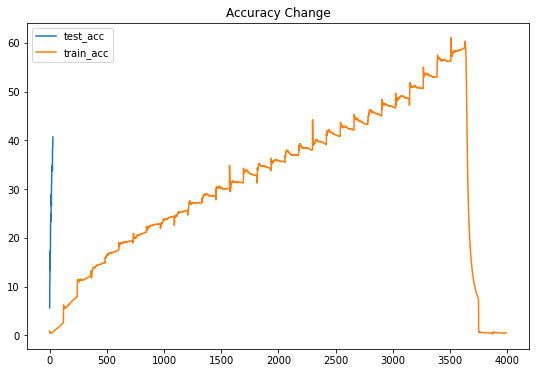

In [0]:
import matplotlib.pyplot as plt
def plot_curve(curves,title,Figsize = (7,7)):
    fig = plt.figure(figsize=Figsize)
    ax = plt.subplot()
    for curve in curves:
        ax.plot(curve[0], label=curve[1])
        plt.title(title)
    ax.legend()
    plt.show()
curves = [(train_test.test_acc,"test_acc"),(train_test.train_acc,"train_acc")]
plot_curve(curves,"Accuracy Change",Figsize = (9,6))